In [1]:
import numpy as np
from scipy.linalg import cho_solve, cho_factor
import matplotlib.pyplot as plt
import matplotlib
cmap = 'bwr'

from PIL import Image

## load data

In [7]:
import os
import pandas as pd
import re

file_path = 'data/hanaro_Apr1/'
filenames = [f"APR{str(i).zfill(5)}.ABS" for i in range(1031, 1039)]
files = [os.path.join(file_path, fname) for fname in filenames]
print(files)

data_list = []
time_list = []
# Read data from files
for file in files:
    data = np.loadtxt(file, skiprows=14)
    # Extract collection time from filename using regex
    # Example filename: Apr01031.0058321.txt -> collection time is the number after the dot
    # Extract collection time from file by reading the header
    collection_time = None
    with open(file, 'r') as f:
        for _ in range(14):  # Read header lines
            line = f.readline()
            match = re.search(r'LABEL:.*?(\d+)s', line)
            if match:
                collection_time = int(match.group(1))
                break
    data_list.append(data)
    time_list.append(collection_time)

['data/hanaro_Apr1/APR01031.ABS', 'data/hanaro_Apr1/APR01032.ABS', 'data/hanaro_Apr1/APR01033.ABS', 'data/hanaro_Apr1/APR01034.ABS', 'data/hanaro_Apr1/APR01035.ABS', 'data/hanaro_Apr1/APR01036.ABS', 'data/hanaro_Apr1/APR01037.ABS', 'data/hanaro_Apr1/APR01038.ABS']


4334.108148054141
7323.214630838613
6434.1497460355895
4810.88606832419
3992.7629392493845
4033.185825644161
4473.193340867536
4410.780414407078


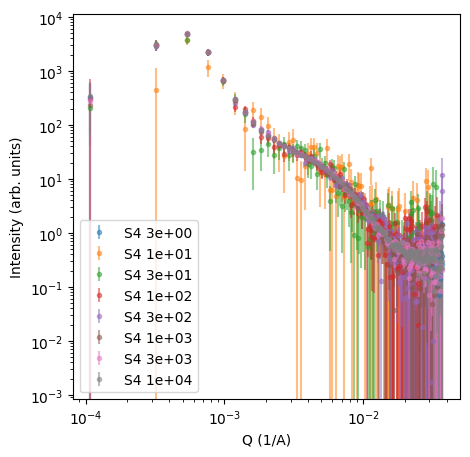

In [8]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

for i, data in enumerate(data_list):
    Q = data[:, 0]
    I = data[:, 1]
    dI = data[:, 2]
    msdI = np.mean(dI**2)
    print(msdI)
    ax.errorbar(Q, I, yerr=dI, fmt='.', label=f'S4 {time_list[i]:.0e}', alpha=0.5)
ax.set_xlabel('Q (1/A)')
ax.set_ylabel('Intensity (arb. units)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()


## define GPR functions

In [9]:
def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)
def f_loglin(x, x_c=1):
    return np.where(x < x_c, (x-x_c)/x_c+np.log(x_c), np.log(x))
def f_loglin_inv(y, y_c=0):
    return np.where(y < y_c, (1+y-y_c)*np.exp(y_c), np.exp(y))
def f_loglin_deriv(x, x_c=1):
    return np.where(x < x_c, 1/x_c, 1/x)



def desmear(Q,IQ,IQ_er,sigma_Q,n=3,sigmascale=1):
    I_ex = IQ
    I_ex_pos = I_ex[2*n:]
    I_ex_neg = I_ex[:-2*n]
    I_ex = I_ex[n:-n]
    sigma_Q_c = sigma_Q[n:-n]/sigmascale
    # sigma_Q_c = Q[n:-n]

    DQ = Q[n:] - Q[:-n]
    DQ_pos = DQ[n:]
    DQ_neg = DQ[:-n]

    I_ex2 = 2*(DQ_neg*I_ex_pos + DQ_pos*I_ex_neg - I_ex*(DQ_pos+DQ_neg))/(DQ_pos*DQ_neg*(DQ_pos+DQ_neg))
    I_des = I_ex - sigma_Q_c**2/2*I_ex2
    Q_des = Q[n:-n]

    # DI_ex = IQ_er
    # DI_ex[DI_ex==0] = np.min(DI_ex[DI_ex>0])
    # DI_ex_pos = DI_ex[2*n:]
    # DI_ex_neg = DI_ex[:-2*n]
    # DI_ex = DI_ex[n:-n]

    # DI_ex2_Sq = 4*((DQ_neg*DI_ex_pos)**2 + (DQ_pos*DI_ex_neg)**2 + ((DQ_neg+DQ_pos)*DI_ex)**2)/(DQ_pos*DQ_neg*(DQ_pos+DQ_neg))
    # DI_des = DI_ex*(1+sigma_Q_c**4/4*DI_ex2_Sq/DI_ex**2)
    
    return I_des

def f_log_likelihood(y, y_err, x, x_err, z_list = np.linspace(0, 0, 1), importance = None, index = None):
    """
    likelihood of y in the distribution of x
    """
    ## average over the ovservation uncertainty   
    log_likelihood = 0   
    sum_weight = 0  
    
    if importance is None:
        importance = np.ones(len(y))
    if index is None:
        index = np.arange(len(y))
    
    for z in z_list:
        weight_z = np.exp(-z**2/2)/np.sqrt(2*np.pi)
        y_z = y + y_err*z
        log_likelihood_z = -0.5 * np.sum((((y_z - x)**2 / x_err**2 + np.log(2 * np.pi * x_err**2))*importance)[index])
        log_likelihood += log_likelihood_z*weight_z
        sum_weight += weight_z
    log_likelihood = log_likelihood/sum_weight
    return log_likelihood

def gpr_core(
    q, I, I_err, I_bg, sigma_scale,
    f_I, f_I_deriv, f_Q, lmbda, index_eval
):
    """
    Shared GPR computation: returns posterior mean and std
    """

    y_data = f_I(I)
    y_bg = f_I(I_bg)
    y = y_data - y_bg
    y_err = I_err * f_I_deriv(I)

    if index_eval is None:
        index_eval = np.ones(len(y), dtype=bool)

    sig_var = np.mean(y[index_eval] ** 2)
    prior_sigma = np.sqrt(sig_var)

    def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
        if std_1 is None:
            std_1 = np.ones_like(q1)
        if std_2 is None:
            std_2 = np.ones_like(q2)
        return np.exp(-(q1[:, None] - q2[None, :])**2 / (2 * lmbda**2)) * std_1[:, None] * std_2[None, :]

    f_y_err = lambda err: sigma_scale**2 * (err**2 / sig_var)
    K_sigma = np.diag(f_y_err(y_err))

    q_tr = f_Q(q)
    K_xx = f_K_rbf(q_tr, q_tr, lmbda) + K_sigma
    K_xs = f_K_rbf(q_tr, q_tr, lmbda)
    k_ss = f_K_rbf(q_tr, q_tr, lmbda)

    L = np.linalg.cholesky(K_xx)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    v = np.linalg.solve(L, K_xs)

    mu_s = K_xs.T @ alpha
    cov_s = k_ss - v.T @ v
    var_s = np.diag(cov_s) * prior_sigma**2
    std_s = np.sqrt(var_s)

    return mu_s, std_s, y, y_err, sig_var

def optimize_m_factor_gpr(
    q, I, I_err, I_bg,
    f_I=lambda I: I, f_inv_I=lambda fI: fI, f_I_deriv=lambda I: np.ones_like(I),
    f_Q=lambda q: q, lmbda=0.25, ax=None, color='k', index_eval=None
):
    sigma_list = np.logspace(-3, 2, 25)
    log_likelihood_list = []

    for sigma in sigma_list:
        mu_s, std_s, y, y_err, _ = gpr_core(
            q=q, I=I, I_err=I_err, I_bg=I_bg, sigma_scale=sigma,
            f_I=f_I, f_I_deriv=f_I_deriv, f_Q=f_Q,
            lmbda=lmbda, index_eval=index_eval
        )
        log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s, index=index_eval)
        log_likelihood_list.append(log_likelihood)

    log_likelihood_list = np.array(log_likelihood_list)
    log_likelihood_list -= log_likelihood_list[-1]
    log_likelihood_list /= len(q)

    if ax is not None:
        ax.plot(sigma_list, log_likelihood_list, '-', color=color)
        ax.set_xscale('log')
        # ax.set_ylim([-5, 5])
        ax.tick_params(direction='in', labelsize=20)
        ax.set_xlabel(r'$m_\sigma$', fontsize=20)
        ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)
        plt.tight_layout()

    sigma_best = sigma_list[np.argmax(log_likelihood_list)]
    return sigma_best

def gpr_posterior_predictive(
    q, I, I_err, I_bg, sigma_best,
    f_I=lambda I: I,
    f_inv_I=lambda fI: fI,
    f_I_deriv=lambda I: np.ones_like(I),
    f_Q=lambda q: q,
    lmbda=0.25,
    index_eval=None
):
    mu_s, std_s, _, _, _ = gpr_core(
        q=q, I=I, I_err=I_err, I_bg=I_bg, sigma_scale=sigma_best,
        f_I=f_I, f_I_deriv=f_I_deriv, f_Q=f_Q,
        lmbda=lmbda, index_eval=index_eval
    )

    y_bg = f_I(I_bg)
    I_mean_GP = f_inv_I(mu_s + y_bg)
    I_std_GP = std_s

    if f_I == f_loglin:
        I_std_GP = std_s / f_loglin_deriv(I, x_c=np.exp(np.max(f_I(I_bg))))

    return I_mean_GP, I_std_GP



In [141]:
# === Inference and Preprocessing Parameters ===
time_list = time_list
data_list = data_list


# Kernel smoothing width (applied to transformed Q)
background_filter_width = 0.4        

# Background level used for log-like intensity transform
background_intensity_offset = 5e-2

# Flags for transformation type
use_log_I = True                    # Apply log transform to I(Q)
use_log_Q = True                    # Apply log transform to Q
lmbda = 0.4                         # RBF kernel length scale

# === Define Q transformation functions ===
if use_log_Q:
    f_Q       = lambda q: np.log(q)
    f_inv_Q   = lambda fq: np.exp(fq)
else:
    f_Q       = lambda q: q
    f_inv_Q   = lambda fq: fq

# === Define I(Q) transformation functions ===
if use_log_I:
    x_c = background_intensity_offset * 2
    y_c = np.log(x_c)
    f_I         = lambda I: f_loglin(I, x_c=x_c)
    f_inv_I     = lambda fI: f_loglin_inv(fI, y_c=y_c)
    f_I_deriv   = lambda I: f_loglin_deriv(I, x_c=x_c)
else:
    f_I         = lambda I: I
    f_inv_I     = lambda fI: fI
    f_I_deriv   = lambda I: np.ones_like(I)
    
    
# === Result Containers ===
list_I_mean_gp = []
list_I_std_gp = []

# === Process each sample ===
# fig, ax = plt.subplots(figsize=(5, 5)) # for plotting optimization of m_factor
for i_t, time in enumerate(time_list):
    # ax = plt.subplot(1, 1, 1) # for plotting optimization of m_factor
    # color = 'k'
    # color = get_viridis_color(i_t / (len(time_list) - 1))

    # === 1. Load and preprocess noisy data ===
    data = data_list[i_t]
    index_positive = data[:, 0] > 0
    q_data = data[index_positive, 0]
    I_data = data[index_positive, 1]
    I_err_data = data[index_positive, 2].copy()

    # Replace zero uncertainties with previous values
    for i in range(1, len(I_err_data)):
        if I_err_data[i] == 0:
            I_err_data[i] = I_err_data[i - 1]

    # Define outlier masks
    index_outlier_sm = (q_data > 1e-2) | (q_data < 1e-4)
    index_outlier = (q_data < 3e-2) & (q_data > 1e-4)

    # === Estimate background using iterative kernel smoothing ===
    I_q_gf = np.zeros_like(q_data)
    for _ in range(1):
        I_q_gf_i = np.zeros_like(q_data)
        I_iter = I_data - I_q_gf
        for i in range(len(q_data)):
            dq = (f_Q(q_data[i]) - f_Q(q_data)) / background_filter_width
            weights = np.exp(-0.5 * dq**2)
            weights[index_outlier_sm] = 0
            weights /= np.sum(weights)
            I_q_gf_i[i] = np.sum(I_iter * weights)
        I_q_gf += I_q_gf_i

    # === 2. Optimize GPR noise scale parameter sigma ===
    # sigma_best = optimize_m_factor_gpr(
    #     q=q_data,
    #     I=I_data,
    #     I_err=I_err_data,
    #     I_bg=I_q_gf,
    #     f_I=f_I,
    #     f_inv_I=f_inv_I,
    #     f_I_deriv=lambda I: f_loglin_deriv(I, x_c=background_intensity_offset * 2),
    #     f_Q=f_Q,
    #     lmbda=lmbda,
    #     ax=ax,
    #     color=color,
    #     index_eval=index_outlier
    # )
    sigma_best = 10

    # === 3. GPR prediction: posterior mean and uncertainty ===
    I_mean_GP, I_std_GP = gpr_posterior_predictive(
        q=q_data,
        I=I_data,
        I_err=I_err_data,
        I_bg=I_q_gf,
        sigma_best=sigma_best,
        f_I=f_I,
        f_inv_I=f_inv_I,
        f_I_deriv=lambda I: f_loglin_deriv(I, x_c=background_intensity_offset * 2),
        f_Q=f_Q,
        lmbda=lmbda,
        index_eval=index_outlier
    )

    # === 4. Store result ===
    list_I_mean_gp.append(I_mean_GP)
    list_I_std_gp.append(I_std_GP)

/tmp/ipykernel_2644768/3638014026.py:5: RuntimeWarning: invalid value encountered in log
  return np.where(x < x_c, (x-x_c)/x_c+np.log(x_c), np.log(x))


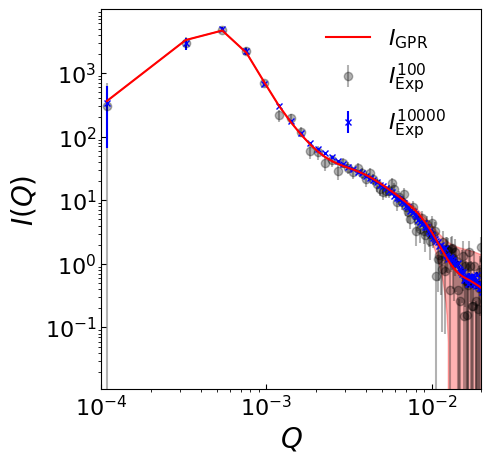

In [ ]:
# === Prepare reference data at long-time limit ===
index_data_good = len(time_list) - 1
data_good = data_list[index_data_good]
index_positive = data_good[:, 0] > 0
q_ref, I_ref, I_err_ref = data_good[index_positive, :3].T

# Replace zeros in error with previous non-zero value
for i in range(1, len(I_err_ref)):
    if I_err_ref[i] == 0:
        I_err_ref[i] = I_err_ref[i - 1]

# === Select GPR prediction for earliest time ===
i_time_exp = 3
data_exp = data_list[i_time_exp]
index_positive_exp = data_exp[:, 0] > 0
q_exp, I_exp, I_err_exp = data_exp[index_positive_exp, :3].T
I_gp = list_I_mean_gp[i_time_exp]
I_gp_err = list_I_std_gp[i_time_exp]
I_bg = 0.5 #guess inc background level

# === Create plot ===
fig, ax = plt.subplots(figsize=(5, 5))

# Experimental data (early time)
ax.errorbar(q_exp, I_exp, yerr=I_err_exp, fmt='o', color='k', ms=6,
            label=fr'$I_\mathrm{{Exp}}^{{{int(time_list[i_time_exp])}}}$', alpha=0.3)

# GPR prediction + uncertainty band
ax.plot(q_exp, I_gp+I_bg, '-r', label=r'$I_\mathrm{GPR}$', zorder=10)
ax.fill_between(q_exp, I_gp+I_bg - I_gp_err, I_gp+I_bg + I_gp_err, color='r', alpha=0.3)

# # plot background
# ax.plot(q_data, I_q_gf, '--', color='g', label=r'$I_\mathrm{bg}$', zorder=5)

# Experimental reference (long-time)
ax.errorbar(q_ref, I_ref, yerr=I_err_ref, fmt='x', color='b', ms=5,
            label=fr'$I_\mathrm{{Exp}}^{{{int(time_list[index_data_good])}}}$')

# === Axis and formatting ===
ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim([0.2, 500])
ax.set_xlim([1e-4, 2e-2])
ax.tick_params(direction='in', labelsize=16)

# Adjust to square aspect in log-log scale
xlim_log = np.log10(ax.get_xlim())
ylim_log = np.log10(ax.get_ylim())
ax.set_aspect((xlim_log[1] - xlim_log[0]) / (ylim_log[1] - ylim_log[0]))

# Legend and layout
ax.legend(frameon=False, fontsize=16, loc='lower center', bbox_to_anchor=(0.75, 0.6))
plt.tight_layout()


Mean Squared Error for time 3: 0.0052
Mean Squared Error for GPR at time 3: 0.0248
Mean Squared Error for time 10: 0.1282
Mean Squared Error for GPR at time 10: 0.2324
Mean Squared Error for time 30: 0.1472
Mean Squared Error for GPR at time 30: 0.1382
Mean Squared Error for time 100: 0.0937
Mean Squared Error for GPR at time 100: 0.1524
Mean Squared Error for time 300: 0.1542
Mean Squared Error for GPR at time 300: 0.2161
Mean Squared Error for time 1000: 0.0715
Mean Squared Error for GPR at time 1000: 0.0653
Mean Squared Error for time 3000: 0.0419
Mean Squared Error for GPR at time 3000: 0.1080
Mean Squared Error for time 10000: 0.0000
Mean Squared Error for GPR at time 10000: 0.0278


/tmp/ipykernel_2644768/1773232732.py:21: RuntimeWarning: invalid value encountered in log
  mse = f_mse((np.log(I_ref)), np.log(I_data))
/tmp/ipykernel_2644768/1773232732.py:22: RuntimeWarning: invalid value encountered in log
  mse_GP = f_mse(np.log(I_ref), np.log(list_I_mean_gp[i_t]))


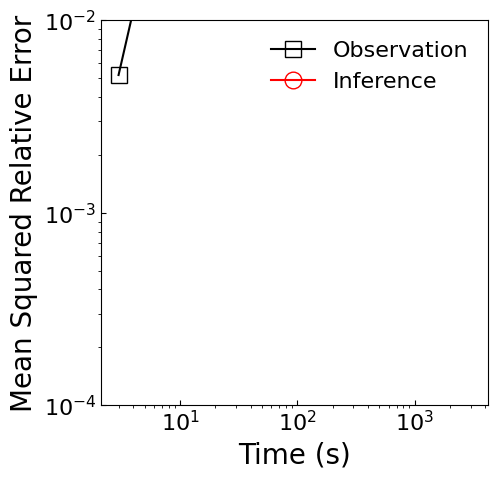

In [143]:
mse_list = []
mse_GP_list = []
index_data_good = len(time_list) - 1
data_good = data_list[index_data_good]
index_positive = data_good[:, 0] > 0
q_ref, I_ref, I_err_ref = data_good[index_positive, :3].T
I_gp_ref = list_I_mean_gp[index_data_good]
I_gp_err_ref = list_I_std_gp[index_data_good]

def f_mse(y, y_gt):
    mask = np.isfinite(y) & np.isfinite(y_gt)
    return np.mean((y[mask] - y_gt[mask])**2)/np.mean((y_gt[mask])**2)

for i_t, data in enumerate(data_list):
    data = data_list[i_t]
    index_positive = data[:, 0] > 0
    q_data = data[index_positive, 0]
    I_data = data[index_positive, 1]
    I_err_data = data[index_positive, 2].copy()

    mse = f_mse((np.log(I_ref)), np.log(I_data))
    mse_GP = f_mse(np.log(I_ref), np.log(list_I_mean_gp[i_t]))
    print(f"Mean Squared Error for time {time_list[i_t]}: {mse:.4f}")
    print(f"Mean Squared Error for GPR at time {time_list[i_t]}: {mse_GP:.4f}")

    mse_list.append(mse)
    mse_GP_list.append(mse_GP)

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(time_list[:-1], mse_list[:-1], 's-', color='k', label='Observation', fillstyle='none', markersize=12)
ax.plot(time_list[:-1], mse_GP_list[:-1], 'o-', color='r', label='Inference', fillstyle='none', markersize=12)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time (s)', fontsize=20)
ax.set_ylabel('Mean Squared Relative Error', fontsize=20)
ax.set_ylim([1e-4, 1e-2])
ax.tick_params(direction='in', labelsize=16)
ax.legend(frameon=False, fontsize=16)

In [136]:
list_I_mean_gp[i_t].shape

(173,)

In [119]:
f_mse

<function __main__.f_mse(y, y_gt)>